In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np

# Read the head and mat files with path
def find_challenge_files(data_directory):
    header_files = list()
    recording_files = list()
    for f in sorted(os.listdir(data_directory)):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

# Load the head file into a string
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

# Get frequency from header.
def get_frequency(header):
    frequency = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency

# Get the labels from header
def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('# Dx') or l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass

    # atrial fibrillation	164889003 -> 0 AF
    if '164889003' in labels:
      return 0

    # sinus rhythm 426783006 -> 1 NSR
    elif '426783006' in labels:
      return 1

    # sinus bradycardia	426177001 SB
    else:
      return 2

# Load the recording file as an array.
# Default 12 leads
def load_recording(recording_file, leads=None, key='val'):
    from scipy.io import loadmat
    recording = loadmat(recording_file)[key]
    if leads == 6:
      recording = recording[:6, :]
    return recording


# Get leads from header.
def get_leads(header):
    leads = list()
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            leads.append(entries[-1])
        else:
            break
    return tuple(leads)

In [3]:
# Get the two list header_files and recording_files
lst = ['g' + str(i) for i in range(1, 12)]

header_files = []
recording_files = []

for i in range(len(lst)):
  address = '/content/drive/MyDrive/data_temp/georgia/' + lst[i]
  head, rec = find_challenge_files(address)
  header_files.extend(head)
  recording_files.extend(rec)

In [4]:
header_files[0]

'/content/drive/MyDrive/data_temp/georgia/g1/E00001.hea'

In [5]:
## Balance the dataset

af_header = []
af_record = []
nsr_header = []
nsr_record = []
other_header = []
other_record = []

for i in range(len(recording_files)):

  ecg = load_header(header_files[i])
  if get_labels(ecg) == 0:
    af_header.append(header_files[i])
    af_record.append(recording_files[i])
  elif get_labels(ecg) == 1:
    nsr_header.append(header_files[i])
    nsr_record.append(recording_files[i])
  else:
    other_header.append(header_files[i])
    other_record.append(recording_files[i])

In [6]:
len(af_record),len(nsr_header),len(other_header)

(570, 1752, 8022)

In [7]:
import random

# 从0到8021中随机选择1800个数字
sampled_numbers = random.sample(range(8022), 1800)

# sampled_numbers 就是随机选择的1800个数字组成的列表
len(sampled_numbers)

1800

In [8]:
header_files = af_header + nsr_header
recording_files = af_record + nsr_record

for i in sampled_numbers:
  header_files.append(other_header[i])
  recording_files.append(other_record[i])

len(header_files)

4122

In [9]:
random_indices = random.sample(range(len(header_files)), len(header_files))

# 根据随机索引重新排列两个列表
shuffled_header = [header_files[i] for i in random_indices]
shuffled_record = [recording_files[i] for i in random_indices]

In [10]:
header_files = shuffled_header
recording_files = shuffled_record

In [11]:
# 小波去噪
import pywt
import numpy as np

def denoise_ecg(ecg_data):
    # 小波去噪参数
    wavelet = 'db4'  # 选择小波基函数
    level = 3  # 小波分解的层数

    # 创建一个一样大小的数组
    denoised_ecg = np.zeros_like(ecg_data)

    for i in range(ecg_data.shape[0]):
        # 对每个导联的心电图信号进行小波分解
        coeffs = pywt.wavedec(ecg_data[i], wavelet, level=level)

        # 根据阈值去除噪声
        threshold = np.std(coeffs[-level]) * np.sqrt(2 * np.log(len(ecg_data[i])))
        coeffs[1:] = (pywt.threshold(c, threshold) for c in coeffs[1:])

        # 重构信号
        denoised_ecg[i] = pywt.waverec(coeffs, wavelet)

    return denoised_ecg

In [12]:
# Heartbeat segmentation
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_peak(ecg_data):

  fs = 500
  # Choose the second lead for R peak
  lead = ecg_data[1]
  threshold = 0.7 * np.max(lead)
  distance = int(0.5 * fs)   # the min distance between two peaks

  peaks, _ = find_peaks(lead, height=threshold, distance=distance)

  # Choose the second peak
  peaks = peaks.tolist()
  if len(peaks) > 1:
    return peaks[1]
  elif len(peaks) == 1:
    return peaks[0]
  else:
    return 0

def segment(ecg_data):
  peak = get_peak(ecg_data)
  selected_data = []
  min_length = 400
  for lead_data in ecg_data:
    if peak <150:
      selected_lead_data = lead_data[ : min_length]
    elif peak >= 4750:
      selected_lead_data = lead_data[4999 - min_length : 4999]
    else:
      selected_lead_data = lead_data[peak - 150:peak + 250]
    selected_data.append(selected_lead_data)

  # Change selected_data into array (6,400)
  selected_data = np.array(selected_data)
  return selected_data

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class MyDataset(Dataset):
    def __init__(self, recording_files, header_files):
        self.recording_files = recording_files
        self.header_files = header_files

    def __len__(self):
        return len(self.recording_files)

    def __getitem__(self, index):
        recording_file = self.recording_files[index]
        header_file = self.header_files[index]

        # Load the data with 6 leads
        raw_data = load_recording(recording_file, leads= 12)
        denoise_data = denoise_ecg(raw_data)
        segment_data = segment(denoise_data)
        ecg_data = torch.tensor(segment_data, dtype=torch.float)

        # Load the label
        label = get_labels(load_header(header_file))

        return ecg_data, label


# Define batch size
batch_size = 64
categroy = 3

In [14]:
import torch.optim as optim
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=20, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=20, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=10, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1216, 64) # 2720
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32) # 32 * 98 = 3136
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 创建模型实例
model = CNN()

# 统计模型参数总数
total_params = count_parameters(model)
print(f"number of parameters: {total_params}")

number of parameters: 118563


In [15]:
# CNN LSTM
import torch
import torch.nn as nn
import torch.optim as optim

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(12, 16, kernel_size=20, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=10, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(16, 16, kernel_size=5, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=256)
        self.fc4 = nn.Linear(256, 20)
        self.dropout4 = nn.Dropout(p=0.2)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(20, 5)
        self.dropout5 = nn.Dropout(p=0.2)
        self.relu5 = nn.ReLU()

        self.fc6 = nn.Linear(215, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc4(x)
        x = self.dropout4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.dropout5(x)
        x = self.relu5(x)
        x = x.view(x.size(0),-1)
        x = self.fc6(x)
        return x

model = CNN_LSTM()

# 统计模型参数总数
total_params = count_parameters(model)
print(f"number of parameters: {total_params}")

number of parameters: 294197


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def train_model(model, criterion, optimizer, num_epochs, k_folds, dataset):


  # 将数据集分为 k_folds 折
  kf = KFold(n_splits=k_folds, shuffle=True)
  for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):

    print(f"Fold {fold+1}")
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_subset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for inputs, labels in train_loader:

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples

        model.eval()  # 切换到评估模式
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for test_inputs, test_labels in val_loader:

                test_outputs = model(test_inputs)
                val_loss += criterion(test_outputs, test_labels).item()

                _, test_predicted = torch.max(test_outputs, 1)
                val_correct += (test_predicted == test_labels).sum().item()
                val_total += test_labels.size(0)


        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)



        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2%}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}")

    plt.figure(figsize=(10, 6))

    # 绘制训练集损失和测试集损失
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练集准确率和测试集准确率
    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Fold 1


/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Epoch [1/10], Train Loss: 1.4722, Train Accuracy: 49.49%, Val Loss: 0.8385, Val Accuracy: 61.97%
Epoch [2/10], Train Loss: 0.8318, Train Accuracy: 62.68%, Val Loss: 0.7862, Val Accuracy: 62.12%
Epoch [3/10], Train Loss: 0.7600, Train Accuracy: 66.06%, Val Loss: 0.7963, Val Accuracy: 62.27%
Epoch [4/10], Train Loss: 0.7292, Train Accuracy: 67.16%, Val Loss: 0.7802, Val Accuracy: 63.03%
Epoch [5/10], Train Loss: 0.7197, Train Accuracy: 67.80%, Val Loss: 0.8017, Val Accuracy: 63.48%
Epoch [6/10], Train Loss: 0.7029, Train Accuracy: 68.98%, Val Loss: 0.7268, Val Accuracy: 65.45%
Epoch [7/10], Train Loss: 0.6732, Train Accuracy: 70.00%, Val Loss: 0.7875, Val Accuracy: 63.64%
Epoch [8/10], Train Loss: 0.6729, Train Accuracy: 70.65%, Val Loss: 0.7210, Val Accuracy: 68.33%
Epoch [9/10], Train Loss: 0.6488, Train Accuracy: 72.35%, Val Loss: 0.7390, Val Accuracy: 66.97%
Epoch [10/10], Train Loss: 0.6534, Train Accuracy: 71.37%, Val Loss: 0.7734, Val Accuracy: 67.88%


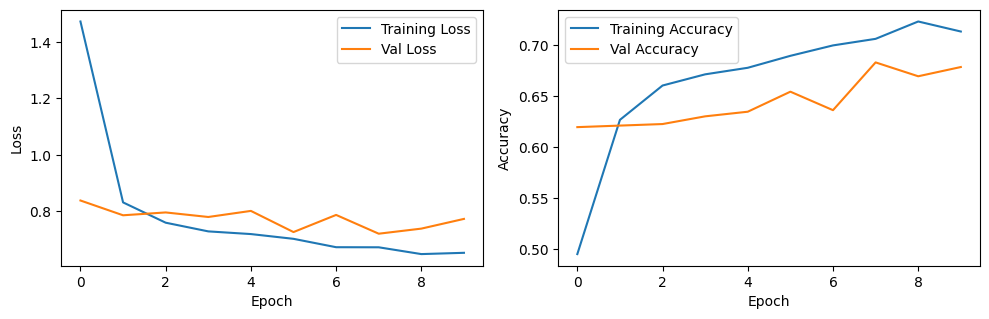

Fold 2
Epoch [1/10], Train Loss: 0.6712, Train Accuracy: 71.71%, Val Loss: 0.6839, Val Accuracy: 71.21%
Epoch [2/10], Train Loss: 0.6435, Train Accuracy: 72.35%, Val Loss: 0.7762, Val Accuracy: 69.70%
Epoch [3/10], Train Loss: 0.6609, Train Accuracy: 72.58%, Val Loss: 0.6847, Val Accuracy: 71.97%
Epoch [4/10], Train Loss: 0.6311, Train Accuracy: 72.47%, Val Loss: 0.6948, Val Accuracy: 70.00%
Epoch [5/10], Train Loss: 0.5972, Train Accuracy: 74.93%, Val Loss: 0.7382, Val Accuracy: 70.30%
Epoch [6/10], Train Loss: 0.5640, Train Accuracy: 77.32%, Val Loss: 0.7472, Val Accuracy: 68.18%
Epoch [7/10], Train Loss: 0.5967, Train Accuracy: 75.84%, Val Loss: 0.7476, Val Accuracy: 68.94%
Epoch [8/10], Train Loss: 0.5664, Train Accuracy: 76.56%, Val Loss: 0.7620, Val Accuracy: 71.67%
Epoch [9/10], Train Loss: 0.5454, Train Accuracy: 77.13%, Val Loss: 0.8224, Val Accuracy: 67.58%
Epoch [10/10], Train Loss: 0.5270, Train Accuracy: 77.85%, Val Loss: 0.8072, Val Accuracy: 68.33%


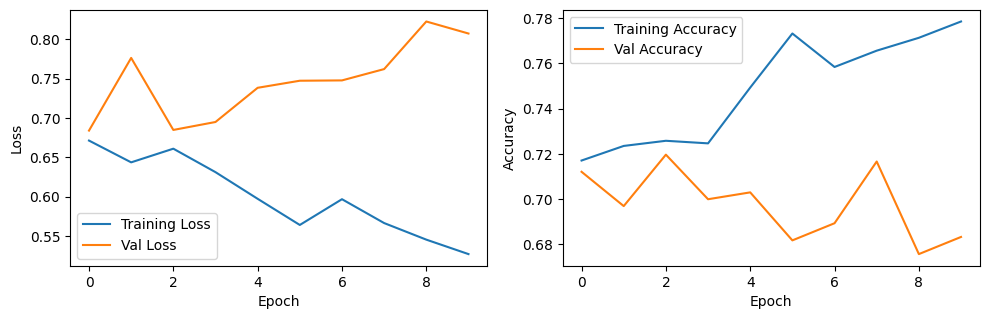

Fold 3
Epoch [1/10], Train Loss: 0.6606, Train Accuracy: 73.43%, Val Loss: 0.6010, Val Accuracy: 74.36%
Epoch [2/10], Train Loss: 0.6094, Train Accuracy: 75.06%, Val Loss: 0.5811, Val Accuracy: 74.20%
Epoch [3/10], Train Loss: 0.6128, Train Accuracy: 74.49%, Val Loss: 0.5886, Val Accuracy: 74.81%
Epoch [4/10], Train Loss: 0.5658, Train Accuracy: 77.67%, Val Loss: 0.6045, Val Accuracy: 73.75%
Epoch [5/10], Train Loss: 0.5336, Train Accuracy: 77.71%, Val Loss: 0.6057, Val Accuracy: 76.48%
Epoch [6/10], Train Loss: 0.5183, Train Accuracy: 79.26%, Val Loss: 0.5992, Val Accuracy: 73.90%
Epoch [7/10], Train Loss: 0.5233, Train Accuracy: 78.89%, Val Loss: 0.6640, Val Accuracy: 73.14%
Epoch [8/10], Train Loss: 0.5202, Train Accuracy: 79.53%, Val Loss: 0.6886, Val Accuracy: 70.86%
Epoch [9/10], Train Loss: 0.5089, Train Accuracy: 78.66%, Val Loss: 0.6015, Val Accuracy: 74.96%
Epoch [10/10], Train Loss: 0.4473, Train Accuracy: 82.03%, Val Loss: 0.6144, Val Accuracy: 74.05%


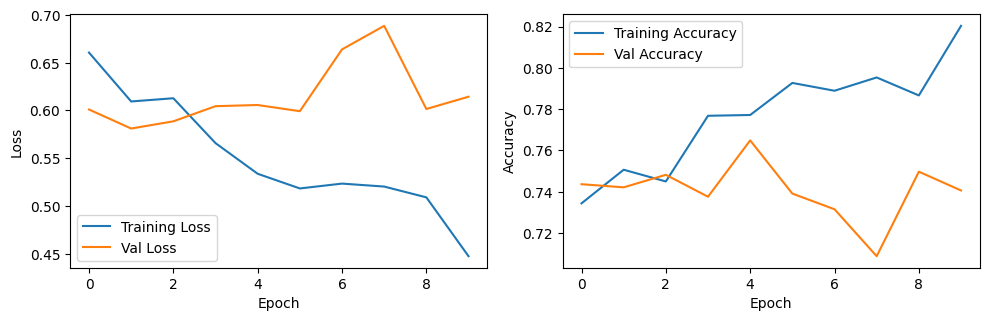

Fold 4
Epoch [1/10], Train Loss: 0.5310, Train Accuracy: 78.43%, Val Loss: 0.4690, Val Accuracy: 82.09%
Epoch [2/10], Train Loss: 0.4950, Train Accuracy: 80.33%, Val Loss: 0.4427, Val Accuracy: 80.58%
Epoch [3/10], Train Loss: 0.5307, Train Accuracy: 78.89%, Val Loss: 0.4705, Val Accuracy: 81.03%
Epoch [4/10], Train Loss: 0.4802, Train Accuracy: 80.40%, Val Loss: 0.4865, Val Accuracy: 79.21%
Epoch [5/10], Train Loss: 0.4919, Train Accuracy: 79.83%, Val Loss: 0.5269, Val Accuracy: 77.54%
Epoch [6/10], Train Loss: 0.4543, Train Accuracy: 81.27%, Val Loss: 0.5902, Val Accuracy: 78.45%
Epoch [7/10], Train Loss: 0.3967, Train Accuracy: 84.23%, Val Loss: 0.6786, Val Accuracy: 78.00%
Epoch [8/10], Train Loss: 0.4393, Train Accuracy: 82.83%, Val Loss: 0.5863, Val Accuracy: 76.48%
Epoch [9/10], Train Loss: 0.3917, Train Accuracy: 83.62%, Val Loss: 0.6240, Val Accuracy: 76.18%
Epoch [10/10], Train Loss: 0.3966, Train Accuracy: 84.61%, Val Loss: 0.7059, Val Accuracy: 73.44%


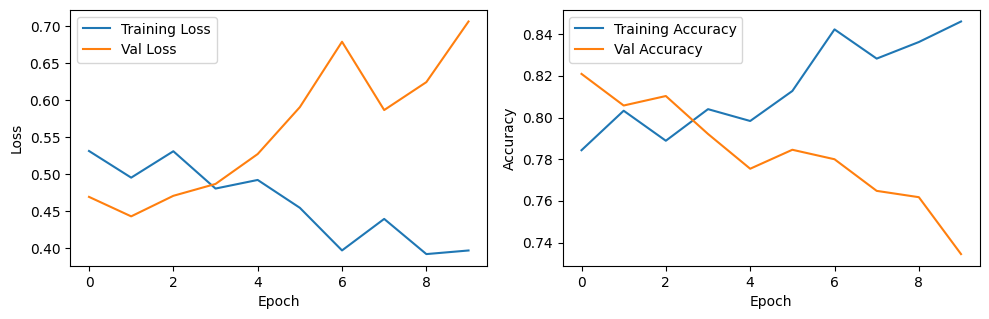

Fold 5
Epoch [1/10], Train Loss: 0.5373, Train Accuracy: 80.29%, Val Loss: 0.3803, Val Accuracy: 84.22%
Epoch [2/10], Train Loss: 0.4681, Train Accuracy: 80.63%, Val Loss: 0.3830, Val Accuracy: 83.92%
Epoch [3/10], Train Loss: 0.3769, Train Accuracy: 85.56%, Val Loss: 0.3831, Val Accuracy: 83.16%
Epoch [4/10], Train Loss: 0.3560, Train Accuracy: 85.67%, Val Loss: 0.4296, Val Accuracy: 82.85%
Epoch [5/10], Train Loss: 0.3961, Train Accuracy: 84.99%, Val Loss: 0.5191, Val Accuracy: 81.18%
Epoch [6/10], Train Loss: 0.4052, Train Accuracy: 83.51%, Val Loss: 0.5270, Val Accuracy: 78.91%
Epoch [7/10], Train Loss: 0.3448, Train Accuracy: 86.73%, Val Loss: 0.5148, Val Accuracy: 80.58%
Epoch [8/10], Train Loss: 0.3301, Train Accuracy: 87.07%, Val Loss: 0.5735, Val Accuracy: 78.60%
Epoch [9/10], Train Loss: 0.3420, Train Accuracy: 86.92%, Val Loss: 0.5235, Val Accuracy: 80.58%
Epoch [10/10], Train Loss: 0.3105, Train Accuracy: 88.21%, Val Loss: 0.6048, Val Accuracy: 78.91%


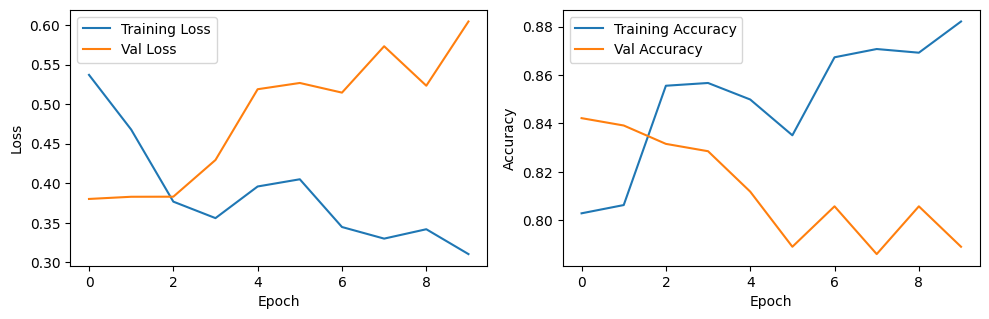

In [18]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
k_folds = 5
num_recordings = len(recording_files)
split_point = int(0.8 * num_recordings)

train_recording = recording_files[:split_point]
test_recording = recording_files[split_point:]
train_header = header_files[:split_point]
test_header = header_files[split_point:]
dataset = MyDataset(train_recording, train_header)
test_dataset = MyDataset(test_recording, test_header)
train_model(model, criterion, optimizer, num_epochs, k_folds, dataset)

In [19]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report
y_pred_list = []
y_true_list = []
testloader = DataLoader(test_dataset, batch_size=batch_size)
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

import numpy as np
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
print(classification_report(y_true, y_pred))

  0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.35      0.42       118
           1       0.67      0.76      0.71       332
           2       0.62      0.61      0.62       375

    accuracy                           0.64       825
   macro avg       0.61      0.57      0.58       825
weighted avg       0.63      0.64      0.63       825



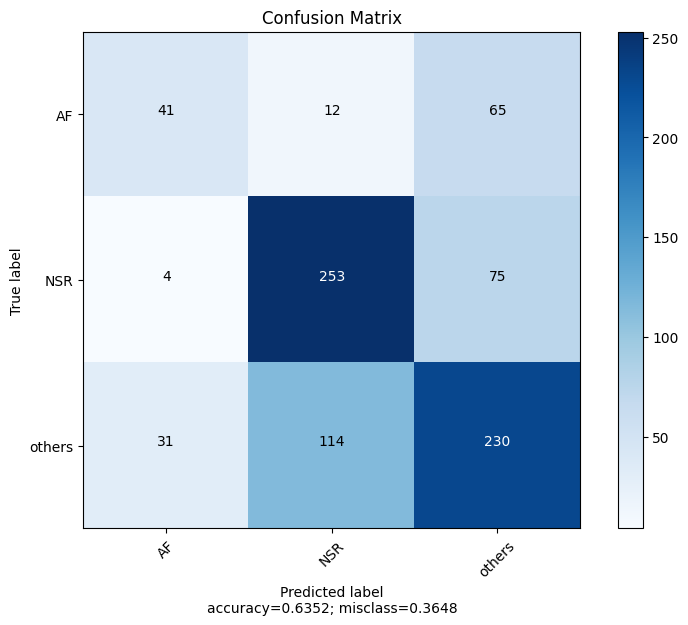

In [20]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['AF','NSR','others'],
                      title        = "Confusion Matrix")

Fold 1


/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Epoch [1/10], Train Loss: 0.9561, Train Accuracy: 52.33%, Val Loss: 0.8665, Val Accuracy: 60.76%
Epoch [2/10], Train Loss: 0.8503, Train Accuracy: 62.65%, Val Loss: 0.8378, Val Accuracy: 62.27%
Epoch [3/10], Train Loss: 0.8188, Train Accuracy: 63.41%, Val Loss: 0.8059, Val Accuracy: 63.94%
Epoch [4/10], Train Loss: 0.7794, Train Accuracy: 65.87%, Val Loss: 0.7674, Val Accuracy: 64.55%
Epoch [5/10], Train Loss: 0.7538, Train Accuracy: 66.33%, Val Loss: 0.7544, Val Accuracy: 63.33%
Epoch [6/10], Train Loss: 0.7366, Train Accuracy: 66.74%, Val Loss: 0.7526, Val Accuracy: 64.39%
Epoch [7/10], Train Loss: 0.7229, Train Accuracy: 69.28%, Val Loss: 0.7379, Val Accuracy: 65.15%
Epoch [8/10], Train Loss: 0.7034, Train Accuracy: 68.98%, Val Loss: 0.7348, Val Accuracy: 65.15%
Epoch [9/10], Train Loss: 0.6936, Train Accuracy: 70.53%, Val Loss: 0.7299, Val Accuracy: 65.76%
Epoch [10/10], Train Loss: 0.6787, Train Accuracy: 70.72%, Val Loss: 0.7143, Val Accuracy: 66.06%


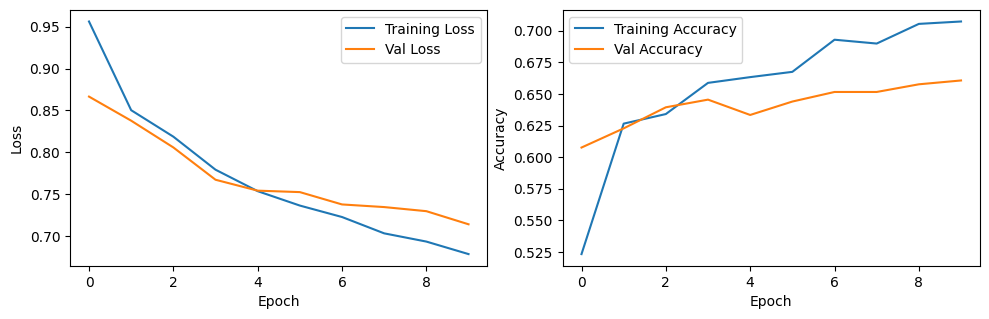

Fold 2
Epoch [1/10], Train Loss: 0.6810, Train Accuracy: 70.19%, Val Loss: 0.6896, Val Accuracy: 69.24%
Epoch [2/10], Train Loss: 0.6811, Train Accuracy: 70.91%, Val Loss: 0.6844, Val Accuracy: 70.61%
Epoch [3/10], Train Loss: 0.6613, Train Accuracy: 71.26%, Val Loss: 0.7013, Val Accuracy: 70.76%
Epoch [4/10], Train Loss: 0.6442, Train Accuracy: 72.54%, Val Loss: 0.7077, Val Accuracy: 69.85%
Epoch [5/10], Train Loss: 0.6394, Train Accuracy: 72.35%, Val Loss: 0.7044, Val Accuracy: 70.30%
Epoch [6/10], Train Loss: 0.6551, Train Accuracy: 72.47%, Val Loss: 0.7024, Val Accuracy: 69.85%
Epoch [7/10], Train Loss: 0.6384, Train Accuracy: 72.35%, Val Loss: 0.6885, Val Accuracy: 71.97%
Epoch [8/10], Train Loss: 0.6425, Train Accuracy: 71.94%, Val Loss: 0.6919, Val Accuracy: 72.58%
Epoch [9/10], Train Loss: 0.6250, Train Accuracy: 73.76%, Val Loss: 0.6812, Val Accuracy: 72.27%
Epoch [10/10], Train Loss: 0.6261, Train Accuracy: 73.11%, Val Loss: 0.6882, Val Accuracy: 71.97%


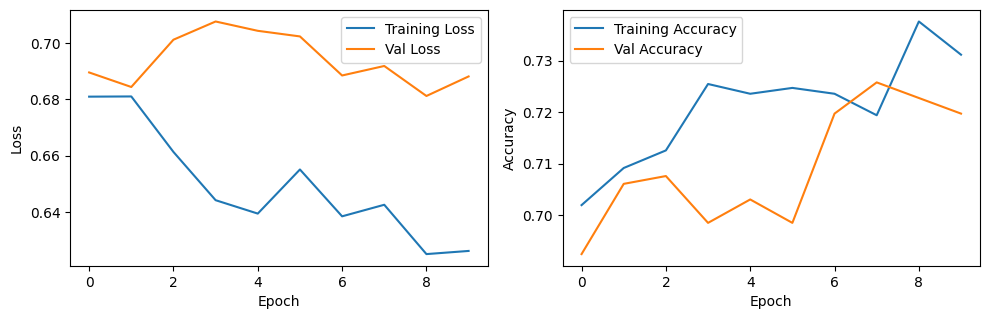

Fold 3
Epoch [1/10], Train Loss: 0.6263, Train Accuracy: 73.01%, Val Loss: 0.6210, Val Accuracy: 72.23%
Epoch [2/10], Train Loss: 0.6132, Train Accuracy: 73.77%, Val Loss: 0.6781, Val Accuracy: 70.71%
Epoch [3/10], Train Loss: 0.6125, Train Accuracy: 73.96%, Val Loss: 0.6918, Val Accuracy: 68.44%
Epoch [4/10], Train Loss: 0.6130, Train Accuracy: 73.58%, Val Loss: 0.6666, Val Accuracy: 69.65%
Epoch [5/10], Train Loss: 0.5927, Train Accuracy: 75.06%, Val Loss: 0.6604, Val Accuracy: 71.62%
Epoch [6/10], Train Loss: 0.6020, Train Accuracy: 74.75%, Val Loss: 0.6560, Val Accuracy: 70.71%
Epoch [7/10], Train Loss: 0.5905, Train Accuracy: 74.79%, Val Loss: 0.6980, Val Accuracy: 69.20%
Epoch [8/10], Train Loss: 0.5835, Train Accuracy: 75.93%, Val Loss: 0.6776, Val Accuracy: 69.95%
Epoch [9/10], Train Loss: 0.5654, Train Accuracy: 75.59%, Val Loss: 0.6902, Val Accuracy: 71.17%
Epoch [10/10], Train Loss: 0.5858, Train Accuracy: 75.47%, Val Loss: 0.6788, Val Accuracy: 70.71%


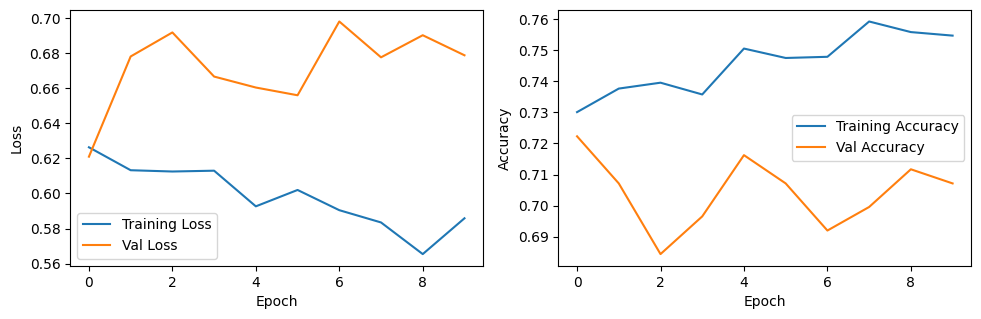

Fold 4
Epoch [1/10], Train Loss: 0.6239, Train Accuracy: 73.50%, Val Loss: 0.5199, Val Accuracy: 76.93%
Epoch [2/10], Train Loss: 0.6148, Train Accuracy: 74.34%, Val Loss: 0.5507, Val Accuracy: 76.78%
Epoch [3/10], Train Loss: 0.6281, Train Accuracy: 73.50%, Val Loss: 0.5360, Val Accuracy: 76.93%
Epoch [4/10], Train Loss: 0.6260, Train Accuracy: 73.73%, Val Loss: 0.5574, Val Accuracy: 75.72%
Epoch [5/10], Train Loss: 0.6183, Train Accuracy: 73.92%, Val Loss: 0.5371, Val Accuracy: 76.78%
Epoch [6/10], Train Loss: 0.6055, Train Accuracy: 74.83%, Val Loss: 0.5572, Val Accuracy: 75.72%
Epoch [7/10], Train Loss: 0.5846, Train Accuracy: 74.79%, Val Loss: 0.5558, Val Accuracy: 76.18%
Epoch [8/10], Train Loss: 0.5936, Train Accuracy: 75.40%, Val Loss: 0.5571, Val Accuracy: 77.09%
Epoch [9/10], Train Loss: 0.5867, Train Accuracy: 74.94%, Val Loss: 0.5525, Val Accuracy: 76.63%
Epoch [10/10], Train Loss: 0.5886, Train Accuracy: 75.97%, Val Loss: 0.5661, Val Accuracy: 76.18%


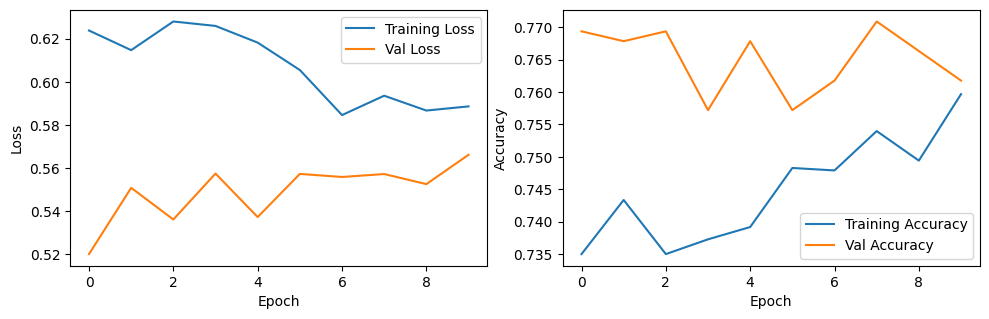

Fold 5
Epoch [1/10], Train Loss: 0.6022, Train Accuracy: 73.58%, Val Loss: 0.5395, Val Accuracy: 77.85%
Epoch [2/10], Train Loss: 0.6029, Train Accuracy: 74.98%, Val Loss: 0.5304, Val Accuracy: 79.97%
Epoch [3/10], Train Loss: 0.5864, Train Accuracy: 76.19%, Val Loss: 0.5317, Val Accuracy: 78.91%
Epoch [4/10], Train Loss: 0.5959, Train Accuracy: 74.45%, Val Loss: 0.5664, Val Accuracy: 76.18%
Epoch [5/10], Train Loss: 0.5811, Train Accuracy: 75.44%, Val Loss: 0.5397, Val Accuracy: 78.30%
Epoch [6/10], Train Loss: 0.5480, Train Accuracy: 76.72%, Val Loss: 0.5311, Val Accuracy: 79.36%
Epoch [7/10], Train Loss: 0.5594, Train Accuracy: 75.74%, Val Loss: 0.5609, Val Accuracy: 77.69%
Epoch [8/10], Train Loss: 0.5647, Train Accuracy: 75.82%, Val Loss: 0.5568, Val Accuracy: 76.63%
Epoch [9/10], Train Loss: 0.5452, Train Accuracy: 76.80%, Val Loss: 0.5499, Val Accuracy: 76.78%
Epoch [10/10], Train Loss: 0.5581, Train Accuracy: 75.40%, Val Loss: 0.5582, Val Accuracy: 77.39%


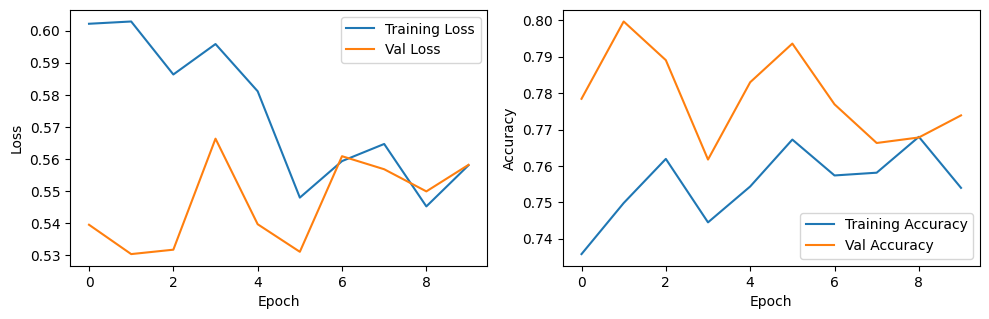

In [ ]:
model = CNN_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
k_folds = 5
num_recordings = len(recording_files)
split_point = int(0.8 * num_recordings)

train_recording = recording_files[:split_point]
test_recording = recording_files[split_point:]
train_header = header_files[:split_point]
test_header = header_files[split_point:]
dataset = MyDataset(train_recording, train_header)
test_dataset = MyDataset(test_recording, test_header)
train_model(model, criterion, optimizer, num_epochs, k_folds, dataset)

In [ ]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report
y_pred_list = []
y_true_list = []
testloader = DataLoader(test_dataset, batch_size=batch_size)
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

import numpy as np
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
print(classification_report(y_true, y_pred))

  0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       128
           1       0.77      0.75      0.76       346
           2       0.66      0.70      0.68       351

    accuracy                           0.69       825
   macro avg       0.66      0.66      0.66       825
weighted avg       0.69      0.69      0.69       825



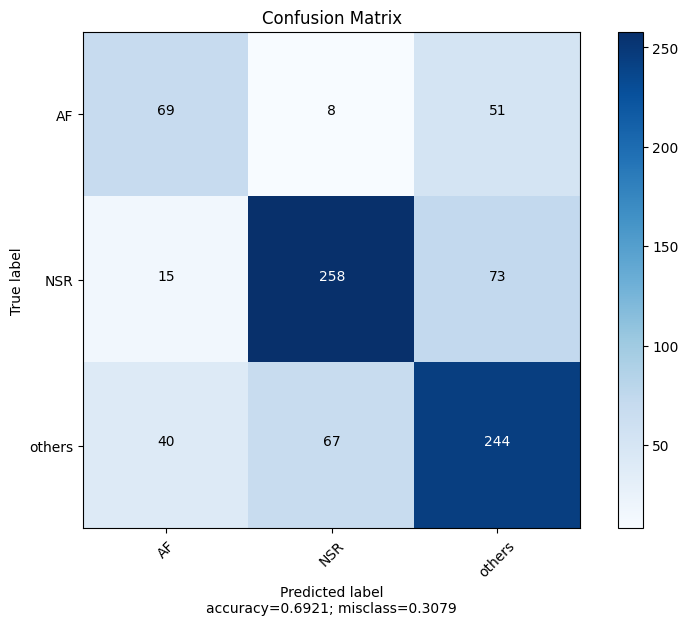

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['AF','NSR','others'],
                      title        = "Confusion Matrix")